# Julia 機器學習：LIBSVM 支撐向量機

## 作業 029：

請使用 SVM 來建立一個預測模型，來對手寫數字辨識資料集，建立一個分類模型，預測數字為何。

本作業需要使用到的套件有 MLDatasets，請在執行以下範例前先安裝。

```
] add MLDatasets
```

In [1]:
using LIBSVM, Statistics, MLDatasets

## 讀取資料

呼叫 MNIST 資料集的過程中，會先去檢查以前是否有下載過，如果是第一次下載，過程中會詢問是否下載資料集，請回答 `y`。

In [2]:
train_X, train_y = MNIST.traindata(1:10000)
test_X,  test_y  = MNIST.testdata(1:1000)

(FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

...

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N

## 資料轉換

In [3]:
typeof(train_X)

Base.ReinterpretArray{FixedPointNumbers.Normed{UInt8,8},3,UInt8,Array{UInt8,3}}

In [4]:
size(train_X)

(28, 28, 10000)

In [5]:
typeof(train_y)

Array{Int64,1}

In [6]:
size(train_y)

(10000,)

In [7]:
train_y[1:5]

5-element Array{Int64,1}:
 5
 0
 4
 1
 9

In [8]:
import Pkg
Pkg.add("PyPlot")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %Fetching: [=====>                                   ]  10.5 %Fetching: [=======>                                 ]  15.5 %Fetching: [=======>                                 ]  16.3 %Fetching: [=======>                                 ]  16.4 %>                            ]  29.0 % [=================>                       ]  41.7 %54.3 %         ]  77.3 %Fetching: [=======================================> ]  96.5 %Fetching: [=======================================> ]  97.1 %

┌ Warning: Some registries failed to update:
│     — /home/ziv/.julia/registries/General — failed to fetch from repo
└ @ Pkg.Types /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.2/Pkg/src/Types.jl:1171


 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


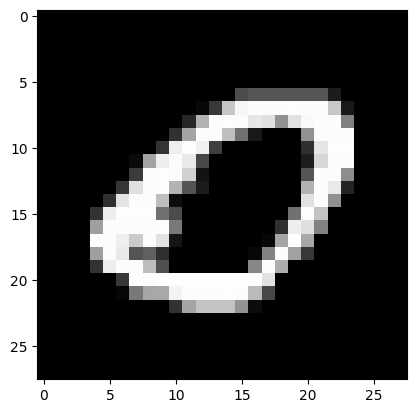

PyObject <matplotlib.image.AxesImage object at 0x7fa34825a3c8>

In [9]:
using PyPlot
img = zeros(size(train_X, 1), 0)
img = hcat(img, train_X[:, :, 2])
imshow(img, cmap="gray")

In [10]:
nrows, ncols = 28, 28
#train_X = Matrix(reshape(train_X, NROWS * NCOLS, :)')
#test_X  = Matrix(reshape(test_X, NROWS * NCOLS, :)')
train_X = reshape(train_X, nrows * ncols, :)'
test_X  = reshape(test_X, nrows * ncols, :)'

1000×784 LinearAlgebra.Adjoint{FixedPointNumbers.Normed{UInt8,8},Base.ReshapedArray{FixedPointNumbers.Normed{UInt8,8},2,Base.ReinterpretArray{FixedPointNumbers.Normed{UInt8,8},3,UInt8,Array{UInt8,3}},Tuple{}}}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0

In [11]:
train_y = ["$x" for x in train_y] # convert to string type
test_y  = ["$x" for x in test_y] # convert to string type

1000-element Array{String,1}:
 "7"
 "2"
 "1"
 "0"
 "4"
 "1"
 "4"
 "9"
 "5"
 "9"
 "0"
 "6"
 "9"
 ⋮  
 "1"
 "6"
 "2"
 "3"
 "9"
 "0"
 "1"
 "2"
 "2"
 "0"
 "8"
 "9"

## 訓練

In [12]:
model = LIBSVM.fit!(SVC(), train_X, train_y)

SVC(LIBSVM.Kernel.RadialBasis, 0.0012755102040816326, nothing, 1.0, 3, 0.0, 0.001, true, false, false, LIBSVM.SVM{String}(SVC, LIBSVM.Kernel.RadialBasis, nothing, 784, 10, ["5", "0", "4", "1", "9", "2", "3", "6", "7", "8"], Int32[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], Float64[], Int32[], LIBSVM.SupportVectors{String,FixedPointNumbers.Normed{UInt8,8}}(5196, Int32[649, 327, 536, 368, 668, 522, 595, 416, 517, 598], ["5", "5", "5", "5", "5", "5", "5", "5", "5", "5"  …  "8", "8", "8", "8", "8", "8", "8", "8", "8", "8"], FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8], Int32[1, 12, 36, 66, 101, 133, 139, 174, 176, 183  …  9926, 9937, 9938, 9945, 9949, 9953, 9957, 9971, 9983, 9997], LIBSVM.SVMNode[LIBSVM.SVMNode(1, 0.0), LIBSVM.SVMNode(1, 0.0), LIBSVM.SVMNode(1, 0.0), LIBSVM.SVMNode(1, 0.0), LIBSVM.SVMNode(1, 0.0), LIBSVM.SVMNode(1, 0.0), LIBSVM.SVMNode(1, 0.0), LIBSVM.SV

## 預測

In [13]:
ŷ = String[]
for i = 1:size(test_X, 1)
    y_ = LIBSVM.predict(model, Matrix(test_X[i, :]'))
    append!(ŷ, y_)
end

## 評估

In [14]:
accuracy(ŷ, y) = mean(ŷ .== y)

accuracy (generic function with 1 method)

In [15]:
accuracy(ŷ, test_y)

0.897